In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("coco-2017", split="validation")

Found annotations at '/Users/keithmatanachai/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [12]:
view_cat = dataset.match({
    "$or": [
        {"ground_truth.detections.label": "zebra"},
        {"ground_truth.detections.label": "pizza"},
    ]
})

export_dir = "./person_vehicle_images"  # replace with your desired path
view_cat.export(
    export_dir=export_dir,
    dataset_type=fo.types.COCODetectionDataset,
    label_field="ground_truth"
)

Directory './person_vehicle_images' already exists; export will be merged with existing files
 100% |█████████████████| 222/222 [654.2ms elapsed, 0s remaining, 339.3 samples/s]      


In [13]:
import fiftyone as fo
import torch
import open_clip
from PIL import Image
import numpy as np

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()

# Load your dataset
dataset_dir = "./person_vehicle_images"
dataset_type = fo.types.COCODetectionDataset
train_dataset = fo.Dataset.from_dir(dataset_dir=dataset_dir, dataset_type=dataset_type)

# Initialize an empty list to store embeddings and paths
embeddings = []
paths = []

# Iterate over the dataset
for sample in train_dataset:
    # Load the image
    image = Image.open(sample.filepath).convert("RGB")

    # Preprocess the image and add batch dimension
    image = preprocess(image).unsqueeze(0)

    # Compute the embedding
    with torch.no_grad():
        image_features = model.encode_image(image)
        embedding = image_features.numpy()

    # Convert to numpy and store
    embeddings.append(embedding)
    paths.append(sample.filepath)

# Convert list of embeddings to a numpy array
embeddings_array = np.vstack([embedding.squeeze() for embedding in embeddings])


/Users/keithmatanachai/Desktop/brain-image-filtering/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 100% |█████████████████| 222/222 [735.7ms elapsed, 0s remaining, 301.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 222/222 [735.7ms elapsed, 0s remaining, 301.8 samples/s]      


In [14]:
np.save("./person_vehicle_embeddings.npy", embeddings_array)
np.save("./person_vehicle_img_paths.npy", paths)

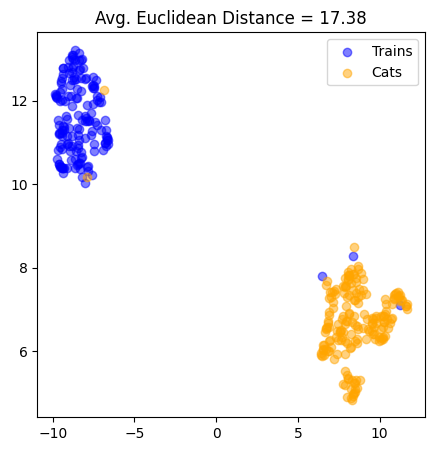

In [27]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Load embeddings
trains_embeddings = np.load('./embeddings/train_embeddings.npy')
cats_embeddings = np.load('./embeddings/cat_embeddings.npy')

# Initialize UMAP reducer
reducer = umap.UMAP()

# Concatenate the two datasets embeddings and apply UMAP
embedding = reducer.fit_transform(np.concatenate((trains_embeddings, cats_embeddings), axis=0))

# Assuming embedding is already computed
trains_len = len(trains_embeddings)
cats_len = len(cats_embeddings)
total_len = trains_len + cats_len

# Initialize variables to calculate average distance
total_distance = 0
count = 0

# Calculate the distance between each pair of points from different datasets
for i in range(trains_len):
    for j in range(trains_len, total_len):
        distance = np.linalg.norm(embedding[i, :] - embedding[j, :])
        total_distance += distance
        count += 1

# Calculate average distance
euclidean_dist = total_distance / count

# Calculate the average Euclidean distance
# euclidean_dist = np.mean(np.linalg.norm(embedding[:len(trains_embeddings), :] - embedding[len(trains_embeddings):, :], axis=1))

# Plotting
plt.figure(figsize=(5, 5))
plt.scatter(embedding[:len(trains_embeddings), 0], embedding[:len(trains_embeddings), 1], c='blue', label='Trains', alpha=0.5)
plt.scatter(embedding[len(trains_embeddings):, 0], embedding[len(trains_embeddings):, 1], c='orange', label='Cats', alpha=0.5)
plt.title(f'Avg. Euclidean Distance = {euclidean_dist:.2f}')
plt.legend()
plt.show()